In [117]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import pyodbc
from datetime import datetime
from dotenv import load_dotenv
import os


# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')


In [118]:
# Funciones generales
# ==============================================================================

load_dotenv()
def get_connection_string():
    server = os.getenv('DB_HOST')
    database = os.getenv('DB_NAME')
    username = os.getenv('DB_USER')
    password = os.getenv('DB_PASSWORD')
    driver = '{ODBC Driver 17 for SQL Server}'
        
    return f'DRIVER={driver};SERVER={server};DATABASE={database};UID={username};PWD={password};'

def get_blob_to_df(table_name : str, connection_str):
    try:
        with pyodbc.connect(connection_str, autocommit=True) as conn:
            query = f"SELECT * FROM {table_name};"
            df = pd.read_sql(query, conn)

        return (True, df)
    except Exception as e:
        return (False, str(e))
    
def guardar_resultados(datos, modelo):
    # Obtener la fecha de ejecución actual
    fecha_ejecucion = datetime.now()
    
    # Crear un nuevo DataFrame con las columnas requeridas
    resultados = pd.DataFrame({
        'DATE_TIME': datos.index,        # Fecha (index)
        'PREDICCION': datos['pred'],       # Columna pred
        'MODELO': modelo,            # Nombre del modelo
        'EXECUTION_DATE': fecha_ejecucion  # Fecha de ejecución
    })
    
    return resultados

def guardar_pronostico(datos, modelo):
    # Obtener la fecha de ejecución actual
    fecha_ejecucion = datetime.now()
    
    # Crear un nuevo DataFrame con las columnas requeridas
    resultados = pd.DataFrame({
        'DATE_TIME': datos.index,        # Fecha (index)
        'PREDICCION': datos['pred'],       # Columna pred
        'MODELO': modelo            # Nombre del modelo
    })
    
    return resultados

def upload_df_to_blob(df: pd.DataFrame, table_name: str, connection_str: str):
    try:
        df = df.where(pd.notnull(df), None)  # Reemplazar NaN por None

        with pyodbc.connect(connection_str, autocommit=True) as conn:
            cursor = conn.cursor()

            # Obtener nombres de columnas y valores de cada fila como tuplas
            columns = ','.join(df.columns)

            # Crear comando SQL para insertar los datos en lotes
            cmd_insert = f"INSERT INTO {table_name} ({columns}) VALUES ({','.join(['?'] * len(df.columns))})"
            cursor.fast_executemany = True
            cursor.executemany(cmd_insert, df.values.tolist())

        return True, ""
    except Exception as e:
        return False, str(e)
    
def upload_df_to_blob_with_steroids(df: pd.DataFrame, table_name: str, connection_str: str):
    try:
        df = df.where(pd.notnull(df), None)  # Reemplazar NaN por None

        with pyodbc.connect(connection_str, autocommit=False) as conn:
            cursor = conn.cursor()
            columns = ','.join(df.columns)
            cmd_insert = f"INSERT INTO {table_name} ({columns}) VALUES ({','.join(['?'] * len(df.columns))})"
            cursor.fast_executemany = True

            batch_size = 5000
            for start in range(0, len(df), batch_size):
                end = start + batch_size
                batch = df.iloc[start:end].values.tolist()
                cursor.executemany(cmd_insert, batch)
                conn.commit()  # Commit después de cada lote

        return True, ""
    except Exception as e:
        return False, str(e)

def crear_tabla_sql(connection_str, sql_create):
    try:
        with pyodbc.connect(connection_str, autocommit=True) as conn:
            cursor = conn.cursor()
            cursor.execute(sql_create)
        print("Tabla creada correctamente.")
    except Exception as e:
        print(f"Error al crear la tabla: {e}")

In [119]:
# Configura la conexión a tu base de datos SQL Server
cnn = get_connection_string()

# Query SQL para extraer datos
_, datos = get_blob_to_df(table_name = 'dbo.flujo_vehicular', connection_str = cnn)


In [96]:
# definimo
# Convertir la columna 'fecha' a objetos datetime
datos['fecha'] = datos['fecha'].astype(str).str.slice(0, 10)
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%d/%m/%Y')

datos.head(20)

,periodo,fecha,hora_inicio,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2017,2017-01-01,0,illia,Centro,Liviano,no cobrado,252
1,2017,2017-01-01,0,illia,Centro,Liviano,efectivo,1
2,2017,2017-01-01,0,illia,Centro,Liviano,telepase,100
3,2017,2017-01-01,0,illia,Centro,Pesado,telepase,2
4,2017,2017-01-01,0,illia,Centro,Pesado,telepase,1
5,2017,2017-01-01,1,illia,Centro,Liviano,no cobrado,73
6,2017,2017-01-01,1,illia,Centro,Liviano,efectivo,10
7,2017,2017-01-01,1,illia,Centro,Liviano,exento,3
8,2017,2017-01-01,1,illia,Centro,Liviano,efectivo,783
9,2017,2017-01-01,1,illia,Centro,Liviano,tarjeta discapacidad,20


**Descripción del dataset de tránsito vehicular:**

Los datos empleados en este documento corresponden al registro del tránsito vehicular en varias estaciones de la ciudad durante el año 2017. El dataset incluye información sobre el número de vehículos que pasaron por cada estación, junto con detalles como el tipo de vehículo, el método de pago utilizado, y la dirección del flujo vehicular. Esta información es útil para análisis de tráfico y gestión del sistema de transporte en la región.

El dataset resultante contiene las siguientes columnas:

| **Columna**        | **Descripción**                                              |
|--------------------|--------------------------------------------------------------|
| `periodo`          | Año del registro o medición.                                 |
| `fecha`            | Fecha en formato día/mes/año.                                |
| `hora_inicio`      | Hora de inicio de la medición.                               |
| `estacion`         | Nombre o código de la estación de medición.                  |
| `sentido`          | Dirección del flujo vehicular (por ejemplo, "Centro").       |
| `tipo_vehiculo`    | Clasificación del vehículo (Liviano, Pesado, etc.).          |
| `forma_pago`       | Método de pago utilizado (efectivo, telepase, no cobrado).    |
| `cantidad_pasos`   | Número de vehículos que pasaron por la estación en ese periodo. |

El dataset permite realizar análisis sobre el comportamiento del tránsito vehicular, incluyendo variaciones por tipo de vehículo, estación, condiciones de pago y horario, lo cual es útil para la planificación de políticas de transporte y el análisis de la eficiencia de los sistemas de monitoreo de tráfico.


## Dimension Tiempo

In [97]:
#encontrar fecha minima y maxima
fecha_min = datos['fecha'].min()
fecha_max = datos['fecha'].max()
print(f"Fecha mínima: {fecha_min}")
print(f"Fecha máxima: {fecha_max}")

# Crea un dataframe que contenga las fechas desde la fecha mínima hasta la fecha máxima
df_fechas = pd.date_range(start=fecha_min, end=fecha_max, freq='D')

# a df_fechas agregar las columnas de DIA_SEMANA, NOMBRE_DIA_SEMANA, DIA_MES, DIA_ANIO, NOMBRE_MES, MES_ANIO, SEMANA_ANIO, ANIO
df_fechas = pd.DataFrame(df_fechas, columns=['FECHA'])
df_fechas['id_fecha'] = df_fechas['FECHA'].dt.strftime('%Y%m%d')
df_fechas['DIA_SEMANA'] = df_fechas['FECHA'].dt.dayofweek
df_fechas['NOMBRE_DIA_SEMANA'] = df_fechas['FECHA'].dt.day_name()
df_fechas['DIA_MES'] = df_fechas['FECHA'].dt.day
df_fechas['DIA_ANIO'] = df_fechas['FECHA'].dt.dayofyear
df_fechas['NOMBRE_MES'] = df_fechas['FECHA'].dt.month_name()
df_fechas['MES_ANIO'] = df_fechas['FECHA'].dt.month
df_fechas['SEMANA_ANIO'] = df_fechas['FECHA'].dt.isocalendar().week
df_fechas['ANIO'] = df_fechas['FECHA'].dt.year
# tambien agregar las columanas BIMESTRE, TRIMESTRE, SEMESTRE Y FERIADO(1 O 0)
df_fechas['BIMESTRE'] = ((df_fechas['FECHA'].dt.month - 1) // 2) + 1
df_fechas['TRIMESTRE'] = ((df_fechas['FECHA'].dt.month - 1) // 3) + 1
df_fechas['SEMESTRE'] = ((df_fechas['FECHA'].dt.month - 1) // 6) + 1
# Definir una lista de feriados con libreria holidays en Peru
import holidays
pe = holidays.PE()
df_fechas['FERIADO'] = df_fechas['FECHA'].apply(lambda x: 1 if x in pe else 0)

# df_fechas
# Intercambiar el orden de las 2 primeras columnas de df_fechas
df_fechas = df_fechas[['id_fecha', 'FECHA'] + [col for col in df_fechas.columns if col not in ['id_fecha', 'FECHA']]]
df_fechas



Fecha mínima: 2017-01-01 00:00:00
Fecha máxima: 2020-12-31 00:00:00


,id_fecha,FECHA,DIA_SEMANA,NOMBRE_DIA_SEMANA,DIA_MES,DIA_ANIO,NOMBRE_MES,MES_ANIO,SEMANA_ANIO,ANIO,BIMESTRE,TRIMESTRE,SEMESTRE,FERIADO
0,20170101,2017-01-01,6,Sunday,1,1,January,1,52,2017,1,1,1,1
1,20170102,2017-01-02,0,Monday,2,2,January,1,1,2017,1,1,1,0
2,20170103,2017-01-03,1,Tuesday,3,3,January,1,1,2017,1,1,1,0
3,20170104,2017-01-04,2,Wednesday,4,4,January,1,1,2017,1,1,1,0
4,20170105,2017-01-05,3,Thursday,5,5,January,1,1,2017,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,20201227,2020-12-27,6,Sunday,27,362,December,12,52,2020,6,4,2,0
1457,20201228,2020-12-28,0,Monday,28,363,December,12,53,2020,6,4,2,0
1458,20201229,2020-12-29,1,Tuesday,29,364,December,12,53,2020,6,4,2,0
1459,20201230,2020-12-30,2,Wednesday,30,365,December,12,53,2020,6,4,2,0


In [105]:

sql_create_tiempo = """
IF NOT EXISTS (SELECT * FROM sysobjects WHERE name='dim_tiempo' AND xtype='U')
BEGIN
    CREATE TABLE dbo.dim_tiempo (
        id_fecha VARCHAR(8) PRIMARY KEY,
        FECHA DATE,
        DIA_SEMANA INT,
        NOMBRE_DIA_SEMANA VARCHAR(20),
        DIA_MES INT,
        DIA_ANIO INT,
        NOMBRE_MES VARCHAR(20),
        MES_ANIO INT,
        SEMANA_ANIO INT,
        ANIO INT,
        BIMESTRE INT,
        TRIMESTRE INT,
        SEMESTRE INT,
        FERIADO BIT
    )
END
"""
crear_tabla_sql(cnn, sql_create_tiempo)

Tabla creada correctamente.


In [106]:
response, msg = upload_df_to_blob(df=df_fechas, table_name = 'dbo.dim_tiempo', connection_str = cnn)
print(f"Response: {response}, Message: {msg}")

Response: True, Message: 


## Dimension Hora

In [98]:
# Crea un DataFrame con las columnas id_hora (incremental desde 1), HORA (de 0 a 23 tipo Time), PERIDO (AM/PM) y HORA_INT (de 0 a 23)
df_horas = pd.DataFrame({
    'id_hora': range(1, 25),
    'HORA': pd.date_range('00:00', '23:00', freq='H').time,
    'PERIODO': ['AM'] * 12 + ['PM'] * 12,
    'HORA_INT': list(range(0, 24))
})
df_horas.head(30)


,id_hora,HORA,PERIODO,HORA_INT
0,1,00:00:00,AM,0
1,2,01:00:00,AM,1
2,3,02:00:00,AM,2
3,4,03:00:00,AM,3
4,5,04:00:00,AM,4
5,6,05:00:00,AM,5
6,7,06:00:00,AM,6
7,8,07:00:00,AM,7
8,9,08:00:00,AM,8
9,10,09:00:00,AM,9


In [25]:
sql_create_hora = """
IF NOT EXISTS (SELECT * FROM sysobjects WHERE name='dim_hora' AND xtype='U')
BEGIN
    CREATE TABLE dbo.dim_hora (
        id_hora INT PRIMARY KEY,
        HORA TIME,
        PERIODO VARCHAR(2),
        HORA_INT INT
    )
END
"""
crear_tabla_sql(cnn, sql_create_hora)

Tabla creada correctamente.


In [26]:
response, msg = upload_df_to_blob(df=df_horas, table_name = 'dbo.dim_hora', connection_str = cnn)
print(f"Response: {response}, Message: {msg}")

Response: True, Message: 


## Dimension Sentido

In [99]:
# Crear un dataframe df_sentido con las columnas id_sentido (incremental desde 1), SENTIDO (valores unicos de la columna 'sentido' del dataframe 'datos')
df_sentido = pd.DataFrame({
    'id_sentido': range(1, len(datos['sentido'].unique()) + 1),
    'SENTIDO': datos['sentido'].unique()
})
df_sentido.head() 

,id_sentido,SENTIDO
0,1,Centro
1,2,Provincia


In [29]:
sql_create_sentido = """
IF NOT EXISTS (SELECT * FROM sysobjects WHERE name='dim_sentido' AND xtype='U')
BEGIN
    CREATE TABLE dbo.dim_sentido (
        id_sentido INT PRIMARY KEY,
        SENTIDO VARCHAR(50)
    )
END
"""
crear_tabla_sql(cnn, sql_create_sentido)

Tabla creada correctamente.


In [30]:
response, msg = upload_df_to_blob(df=df_sentido, table_name = 'dbo.dim_sentido', connection_str = cnn)
print(f"Response: {response}, Message: {msg}")

Response: True, Message: 


## Dimension Tipo de Vehiculo

In [100]:
# Crear un dataframe df_tipo_vehiculo con las columnas id_tipo_vehiculo (incremental desde 1), TIPO_VEHICULO (valores unicos de la columna 'tipo_vehiculo' del dataframe 'datos')
df_tipo_vehiculo = pd.DataFrame({
    'id_tipo_vehiculo': range(1, len(datos['tipo_vehiculo'].unique()) + 1),
    'TIPO_VEHICULO': datos['tipo_vehiculo'].unique()
})
df_tipo_vehiculo.head(20)

,id_tipo_vehiculo,TIPO_VEHICULO
0,1,Liviano
1,2,Pesado
2,3,Auto
3,4,Auto con trailer
4,5,Moto
5,6,N/D
6,7,Pago Doble Auto
7,8,Pesados 2 Ejes
8,9,Pesados 3 Ejes
9,10,Pesados 4 Ejes


In [33]:
sql_create_tipo_vehiculo = """
IF NOT EXISTS (SELECT * FROM sysobjects WHERE name='dim_tipo_vehiculo' AND xtype='U')
BEGIN
    CREATE TABLE dbo.dim_tipo_vehiculo (
        id_tipo_vehiculo INT PRIMARY KEY,
        TIPO_VEHICULO VARCHAR(50)
    )
END
"""
crear_tabla_sql(cnn, sql_create_tipo_vehiculo)

Tabla creada correctamente.


In [34]:
response, msg = upload_df_to_blob(df=df_tipo_vehiculo, table_name = 'dbo.dim_tipo_vehiculo', connection_str = cnn)
print(f"Response: {response}, Message: {msg}")

Response: True, Message: 


## Dimension Forma de Pago

In [101]:
# Crear un dataframe df_forma_pago con las columnas id_forma_pago (incremental desde 1), FORMA_PAGO (valores unicos de la columna 'forma_pago' del dataframe 'datos')
df_forma_pago = pd.DataFrame({
    'id_forma_pago': range(1, len(datos['forma_pago'].unique()) + 1),
    'FORMA_PAGO': datos['forma_pago'].unique()
})
df_forma_pago.head(20)

,id_forma_pago,FORMA_PAGO
0,1,no cobrado
1,2,efectivo
2,3,telepase
3,4,exento
4,5,tarjeta discapacidad
5,6,infraccion
6,7,monedero
7,8,rec.deuda
8,9,tarjeta magnética
9,10,tag


In [36]:
sql_create_forma_pago = """
IF NOT EXISTS (SELECT * FROM sysobjects WHERE name='dim_forma_pago' AND xtype='U')
BEGIN
    CREATE TABLE dbo.dim_forma_pago (
        id_forma_pago INT PRIMARY KEY,
        FORMA_PAGO VARCHAR(50)
    )
END
"""
crear_tabla_sql(cnn, sql_create_forma_pago)

Tabla creada correctamente.


In [ ]:
response, msg = upload_df_to_blob(df=df_forma_pago, table_name = 'dbo.dim_forma_pago', connection_str = cnn)
print(f"Response: {response}, Message: {msg}")

Response: False, Message: ('23000', "[23000] [Microsoft][ODBC Driver 17 for SQL Server][SQL Server]Violation of PRIMARY KEY constraint 'PK__dim_form__DA9B39EEAD693E9B'. Cannot insert duplicate key in object 'dbo.dim_forma_pago'. The duplicate key value is (1). (2627) (SQLExecute); [23000] [Microsoft][ODBC Driver 17 for SQL Server][SQL Server]The statement has been terminated. (3621); [23000] [Microsoft][ODBC Driver 17 for SQL Server][SQL Server]Violation of PRIMARY KEY constraint 'PK__dim_form__DA9B39EEAD693E9B'. Cannot insert duplicate key in object 'dbo.dim_forma_pago'. The duplicate key value is (2). (2627); [23000] [Microsoft][ODBC Driver 17 for SQL Server][SQL Server]The statement has been terminated. (3621); [23000] [Microsoft][ODBC Driver 17 for SQL Server][SQL Server]Violation of PRIMARY KEY constraint 'PK__dim_form__DA9B39EEAD693E9B'. Cannot insert duplicate key in object 'dbo.dim_forma_pago'. The duplicate key value is (3). (2627); [23000] [Microsoft][ODBC Driver 17 for SQL S

## Hecho flujo vehicular

In [ ]:

datos['hora_inicio'] = datos['hora_inicio'].astype(int)
df_fact_flujo = pd.DataFrame({
    'id_flujo': range(1, len(datos) + 1),
    'CANTIDAD_PASOS': datos['cantidad_pasos'],
    'fk_hora': datos['hora_inicio'].map(df_horas.set_index('HORA_INT')['id_hora'].to_dict()),
    'fk_sentido': datos['sentido'].map(df_sentido.set_index('SENTIDO')['id_sentido'].to_dict()),
    'fk_tipo_vehiculo': datos['tipo_vehiculo'].map(df_tipo_vehiculo.set_index('TIPO_VEHICULO')['id_tipo_vehiculo'].to_dict()),
    'fk_forma_pago': datos['forma_pago'].map(df_forma_pago.set_index('FORMA_PAGO')['id_forma_pago'].to_dict()),
    'fk_tiempo': datos['fecha'].dt.date.map(df_fechas.set_index('FECHA')['id_fecha'].to_dict())
})
df_fact_flujo.head(20)

,id_flujo,CANTIDAD_PASOS,fk_hora,fk_sentido,fk_tipo_vehiculo,fk_forma_pago,fk_tiempo
0,1,252,1,1,1,1,20170101
1,2,1,1,1,1,2,20170101
2,3,100,1,1,1,3,20170101
3,4,2,1,1,2,3,20170101
4,5,1,1,1,2,3,20170101
5,6,73,2,1,1,1,20170101
6,7,10,2,1,1,2,20170101
7,8,3,2,1,1,4,20170101
8,9,783,2,1,1,2,20170101
9,10,20,2,1,1,5,20170101


In [114]:
sql_create_fact_flujo = """
IF NOT EXISTS (SELECT * FROM sysobjects WHERE name='fact_flujo' AND xtype='U')
BEGIN
    CREATE TABLE dbo.fact_flujo (
        id_flujo INT PRIMARY KEY,
        CANTIDAD_PASOS INT,
        fk_hora INT,
        fk_sentido INT,
        fk_tipo_vehiculo INT,
        fk_forma_pago INT,
        fk_tiempo VARCHAR(8),
        FOREIGN KEY (fk_hora) REFERENCES dim_hora(id_hora),
        FOREIGN KEY (fk_sentido) REFERENCES dim_sentido(id_sentido),
        FOREIGN KEY (fk_tipo_vehiculo) REFERENCES dim_tipo_vehiculo(id_tipo_vehiculo),
        FOREIGN KEY (fk_forma_pago) REFERENCES dim_forma_pago(id_forma_pago),
        FOREIGN KEY (fk_tiempo) REFERENCES dim_tiempo(id_fecha)
    )
END
"""
crear_tabla_sql(cnn, sql_create_fact_flujo)

Tabla creada correctamente.


In [115]:
response, msg = upload_df_to_blob_with_steroids(df=df_fact_flujo, table_name = 'dbo.fact_flujo', connection_str = cnn)
print(f"Response: {response}, Message: {msg}")

Response: True, Message: 


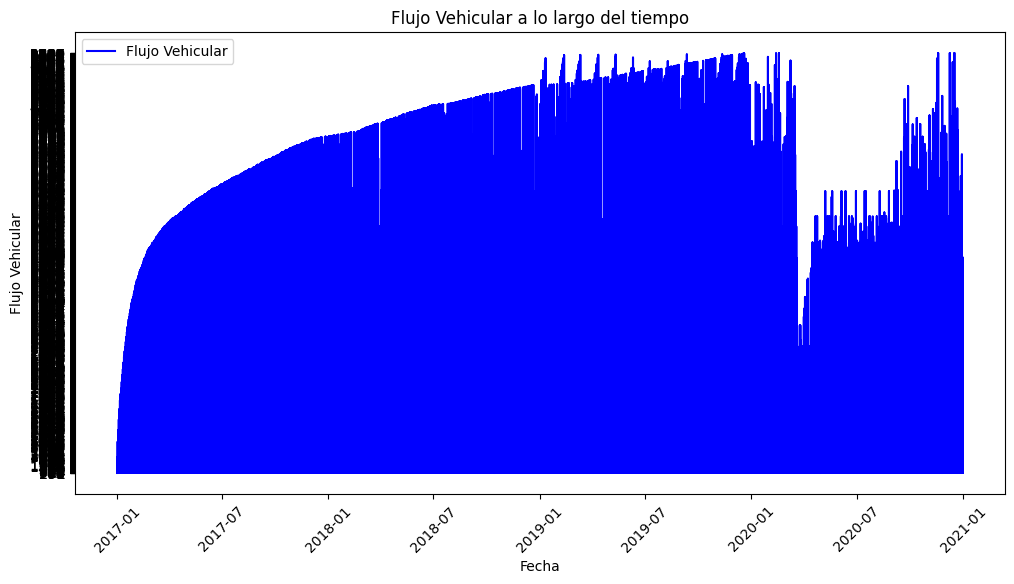

In [14]:
# crea un grafico temporal de la serie de tiempo
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(datos['fecha'], datos['cantidad_pasos'], label='Flujo Vehicular', color='blue')
plt.title('Flujo Vehicular a lo largo del tiempo')
plt.xlabel('Fecha')
plt.ylabel('Flujo Vehicular')
plt.xticks(rotation=45)
plt.legend()